# Forecasting seat availability using random forests

[La Permanence](https://www.la-permanence.com) offers coworking space at two locations in Paris (*rue du Fer à Moulin* and *rue d'Alésia*).  

In this notebook we investigate the effectiveness of random forests in predicting the number of available seats for the next two weeks.  The results depicted below show that random forests are quite effective in picking up the general behavior in the availability of seats.  Random forests are the least effective when availability is particularly low and high.

The code in this notebook follows closely lessons 1 through 4 of fastai's [Introduction to Machine Learning for Coders](http://course18.fast.ai/ml) course.  The corresponding notebooks from the course's github repository are [lesson1-rf.ipynb and lesson2-rf-interpretation.ipynb](https://github.com/fastai/fastai/tree/master/courses/ml1).  This notebook uses [version 0.7](https://github.com/fastai/fastai/tree/master/old/fastai) of the fastai library.

## Imports

In [1]:
import os
import sys
import re
# from tqdm import tqdm  # class tqdm.tqdm imported from fastai.structured - see below

import pytz
import datetime

import math
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# The fastai repository is cloned into ~/Computing on my computer
# Version 0.7 of the fastai library is in fastai/old in the repository
sys.path.append(os.path.join(os.path.expanduser("~"), "Computing/fastai/old"))
from fastai.structured import *

import matplotlib.pyplot as plt

%matplotlib inline

## Constants

In [2]:
# Timezones
tz_utc = pytz.timezone("UTC")  # timestamp is in UTC standard
tz_paris = pytz.timezone("Europe/Paris")  # locations are in Paris, France

# Resampling rule: resolution of time regularization
RESOL = 10
RULE = f"{RESOL}T"
TWO_WEEKS = 2*7*24*(60 // RESOL)  # validation period is two weeks

# Colors for plotting
COL_ALESIA = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
COL_MOULIN = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
COL_TRAIN = plt.rcParams['axes.prop_cycle'].by_key()['color'][2]
COL_VALID = plt.rcParams['axes.prop_cycle'].by_key()['color'][3]
COL_PREDICT = plt.rcParams['axes.prop_cycle'].by_key()['color'][4]

## Helper functions  

In [3]:
def split_vals(df, n):
    """Split data into training and validation sets."""
    return df[:n].copy(), df[n:].copy()
        
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

## Data
The dataset is saved in a `csv` file located in `~/Projects/la_permanence/attendance.csv`.  

**Note**: `attendance.csv` is a misnomer, as the file actually records the number of *available* seats, rather than the number of seats used.  

### Metadata on the dataset

In [4]:
filename = 'attendance.csv'
foldername = 'Projects/la_permanence'
filepath = os.path.join(os.path.expanduser("~"), foldername, filename)
filesize = os.path.getsize(filepath)

COL_WIDTH = 20  # for display in this cell

if filesize > 1e6:
    print("{0}{1:d}MB".format("File size:".ljust(COL_WIDTH), filesize//int(1e6)))
elif filesize > 1e3:
    print("{0}{1:d}KB".format("File size:".ljust(COL_WIDTH), filesize//int(1e3)))
else:
    print("{0}{1:d}B".format("File size:".ljust(COL_WIDTH), filesize))

line_number = !wc -l < {filepath}
line_number = int(line_number[0])
print("{0}{1}".format("Number of rows:".ljust(COL_WIDTH), line_number))
first_row = !head -1 {filepath}
column_names = first_row[0].split(',')
print("{0}{1}".format("Names of columns:".ljust(COL_WIDTH), ", ".join(column_names)))


File size:          1MB
Number of rows:     40995
Names of columns:   timestamp, Moulin, Alésia


### More details on the columns
-  `timestamp` gives the date and time (UTC) of data collection in the format "YYYY-MM-DD-hh-mm-ss" where
`YYYY=year`,
`MM=month`,
`DD=day`,
`hh=hour`,
`mm=minute`,
`ss=second`;  
-  `Moulin` gives the number of available seats at the rue du Fer à Moulin location (maximum is 63);
-  `Alésia` gives the number of available seats at the rue d'Alésia location (maximum is 82).  

### Load the data

In [5]:
# %%prun
%time
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d-%H-%M-%S')

raw_data = pd.read_csv(
    filepath,
    sep=',',
    dtype={'Moulin': np.uint8, 'Alésia': np.uint8},
    parse_dates=['timestamp'],
    date_parser=dateparse
)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


### Adjusting for timezones

The `timestamp` values are in the UTC standard, while the coworking spaces are located in Paris, France:

In [6]:
%time
raw_data['timestamp'] = raw_data['timestamp'].apply(lambda ts: ts.tz_localize(tz_utc).tz_convert(tz_paris))

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.77 µs


### Time regularization

The data is collected at irregular times and thus we resample (at a resolution specified in `RULE`) and interpolate to regularize the data:

In [7]:
raw_data.set_index("timestamp", inplace=True)
raw_data = raw_data.resample(RULE).mean().interpolate().round().astype(np.uint8)
raw_data.reset_index('timestamp', inplace=True)

## Visualizing the time series

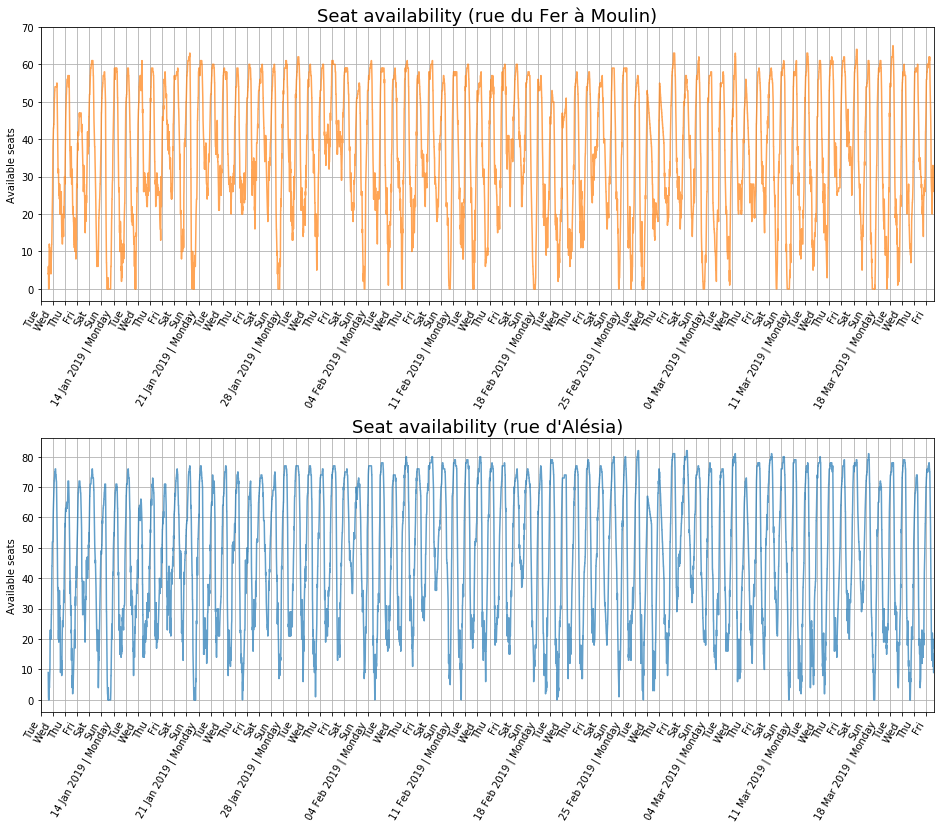

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 14));
plt.subplots_adjust(hspace=0.5)

ts_min = raw_data['timestamp'].min()
ts_max = raw_data['timestamp'].max()
the_date_range = pd.date_range(ts_min.date(), ts_max.date());

# rue du Fer à Moulin
raw_data.plot(x='timestamp', y='Moulin', color=COL_MOULIN, alpha=0.7, ax=ax1);

ax1.set_title("Seat availability (rue du Fer à Moulin)", fontsize=18)

ax1.set_ylabel("Available seats");
ax1.set_yticks(range(0, 80, 10))

ax1.axes.get_xaxis().label.set_visible(False);
ax1.set_xticks(the_date_range);
ax1.set_xticklabels([pd.to_datetime(x).strftime("%d %b %Y | %A")
                     if x.weekday() in [0]
                     else pd.to_datetime(x).strftime("%a")
                     for x in the_date_range])
ax1.tick_params(axis='x', labelrotation=60)

ax1.get_legend().remove();
ax1.grid()

# rue d'Alésia
raw_data.plot(x='timestamp', y='Alésia', color=COL_ALESIA, alpha=0.7, ax=ax2);

ax2.set_title("Seat availability (rue d'Alésia)", fontsize=18)

ax2.set_ylabel("Available seats");
ax2.set_yticks(range(0, 90, 10))

ax2.axes.get_xaxis().label.set_visible(False);
ax2.set_xticks(the_date_range);
ax2.set_xticklabels([pd.to_datetime(x).strftime("%d %b %Y | %A")
                     if x.weekday() in [0]
                     else pd.to_datetime(x).strftime("%a")
                     for x in the_date_range])
ax2.tick_params(axis='x', labelrotation=60)

ax2.get_legend().remove();
ax2.grid()

# plt.savefig("La-Permanence-availability.png")

## Forecasting using random forests

### Performance metrics and parameter values

There are many parameters in [`sklearn.RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) that can be adjusted in order to improve the predictions and we will focus on the following.  
-  The number of trees: `n_estimators`; the default value is (currently) **10** (soon to be changed to 100)
.   
-  The minimum number of samples required to be at a leaf node: `min_leaves_sample`; the default value is **1**.  
-  The maximum number of features to consider when looking for the best split: `max_features`; the default is to use **all** features.  

The choice of values for these parameters is dictated by the metrics used to assess the performance of random forests.  Here we measure:  
- the root mean squared error (RMSE) and  
- the $R^2$ score.  

Near optimal choices have been determined empirically in the notebook `la-permanence-random-forests-parameters.ipynb`.

### Expanding date information

The data is a pure time series: the only independent variable (or feature) is the timestamp.  In order to use random forests, we expand this data into distinct features.  

The next cell extracts particular date fields from a complete datetime for the purpose of constructing categoricals: `Year`, `Month`, `Week`, `Day`, `Dayofweek`, `Dayofyear`, `Is_month_end`, `Is_month_start`, `Is_quarter_end`, `Is_quarter_start`, `Is_year_end`, `Is_year_start`, `Hour`, `Minute`, `Second`.  Of course, not all of these will be useful or even relevant, and for the purpose of exploration we keep them all in the dataframe for the moment.  

In [9]:
timestamps = raw_data.loc[:, ['timestamp']]
add_datepart(raw_data, 'timestamp', time=True)

## Rue du Fer à Moulin
We begin with the data from rue du Fer à Moulin.

### Separating dependent from independent variables  

In [10]:
df, y, nas = proc_df(raw_data.drop('Alésia', axis=1), 'Moulin')

### Splitting data into training and validation sets  

In [11]:
n_valid = TWO_WEEKS  
n_trn = raw_data.shape[0] - n_valid

X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

# For plotting purposes:
timestamps_train = timestamps.iloc[0:n_trn].copy()
timestamps_valid = timestamps.iloc[n_trn:].copy()

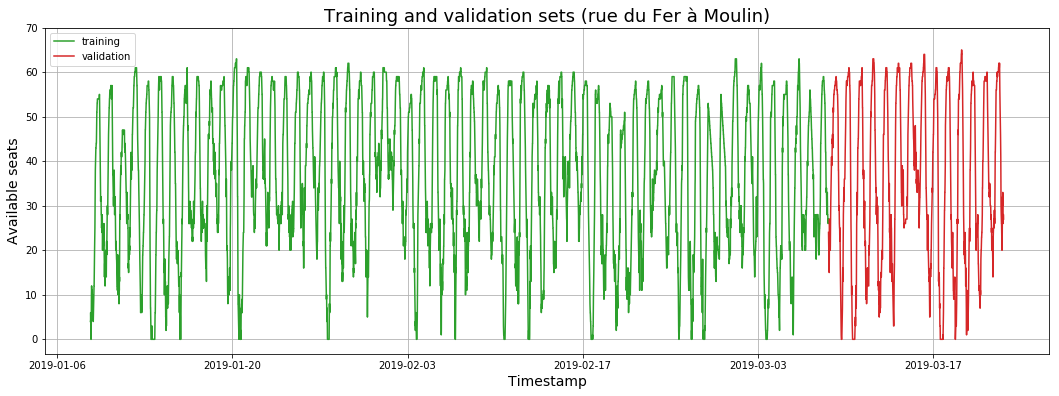

In [12]:
fig, ax = plt.subplots(figsize=(18, 6));

plt.plot(timestamps_train['timestamp'], y_train, COL_TRAIN);
plt.plot(timestamps_valid['timestamp'], y_valid, COL_VALID);

ax.set_title("Training and validation sets (rue du Fer à Moulin)", fontsize=18)

ax.set_ylabel("Available seats", fontsize=14);
ax.set_yticks(range(0, 80, 10));

ax.set_xlabel("Timestamp", fontsize=14);

ax.legend(['training', 'validation'], loc='upper left')
ax.grid();
# plt.savefig("moulin-training-validation-split.png")

## Parameter values
For rue du Fer à Moulin we will set:

In [13]:
nb_trees, max_features, min_leaves = 100, 15, 50

In [14]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=nb_trees, max_features=max_features, min_samples_leaf=min_leaves)
%time m.fit(X_train, y_train)
COL_WIDTH = 20
print("{0}: {1}".format("RMSE (train)".ljust(COL_WIDTH), rmse(m.predict(X_train), y_train)))
print("{0}: {1}".format("RMSE (validation)".ljust(COL_WIDTH), rmse(m.predict(X_valid), y_valid)))
print("{0}: {1}".format("R2 (train)".ljust(COL_WIDTH), m.score(X_train, y_train)))
print("{0}: {1}".format("R2 (validation)".ljust(COL_WIDTH), m.score(X_valid, y_valid)))

y_predict = m.predict(X_valid)

CPU times: user 980 ms, sys: 25.5 ms, total: 1.01 s
Wall time: 146 ms
RMSE (train)        : 4.511220729725197
RMSE (validation)   : 6.6179500387640795
R2 (train)          : 0.9313842924657842
R2 (validation)     : 0.8832723218371192


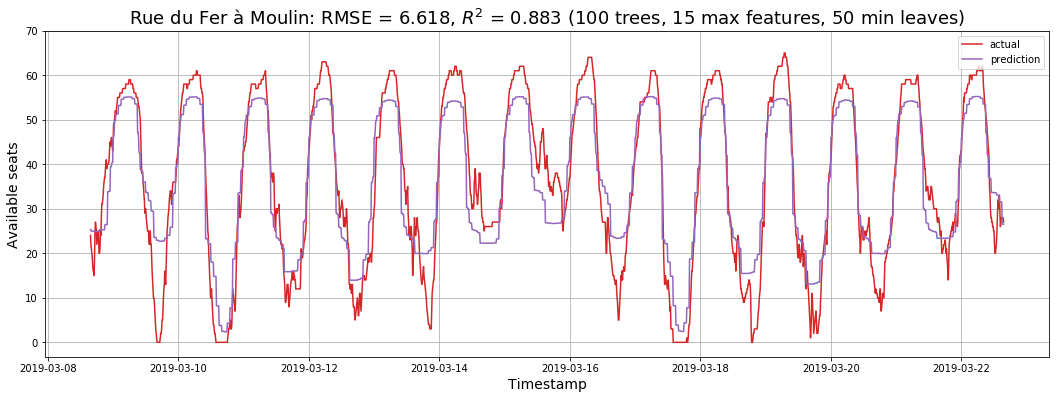

In [15]:
fig, ax = plt.subplots(figsize=(18, 6));
ax.plot(timestamps_valid['timestamp'], y_valid, COL_VALID);
ax.plot(timestamps_valid['timestamp'], y_predict, COL_PREDICT);
ax.set_title(
    "Rue du Fer à Moulin: RMSE = {0:.4g}, $R^2$ = {1:.3g} ({2} trees, {3} max features, {4} min leaves)".format(
        rmse(m.predict(X_valid), y_valid),
        m.score(X_valid, y_valid),
        nb_trees,
        max_features,
        min_leaves
    ),
    fontsize=18
);

ax.set_ylabel("Available seats", fontsize=14);
ax.set_yticks(range(0, 80, 10));
ax.set_xlabel("Timestamp", fontsize=14);
ax.legend(['actual', 'prediction'], loc='upper right')
ax.grid();
# plt.savefig("moulin-random-forests.png");

## Rue d'Alésia

We now consider the data from rue d'Alésia.

In [16]:
df, y, nas = proc_df(raw_data.drop('Moulin', axis=1), 'Alésia')

X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

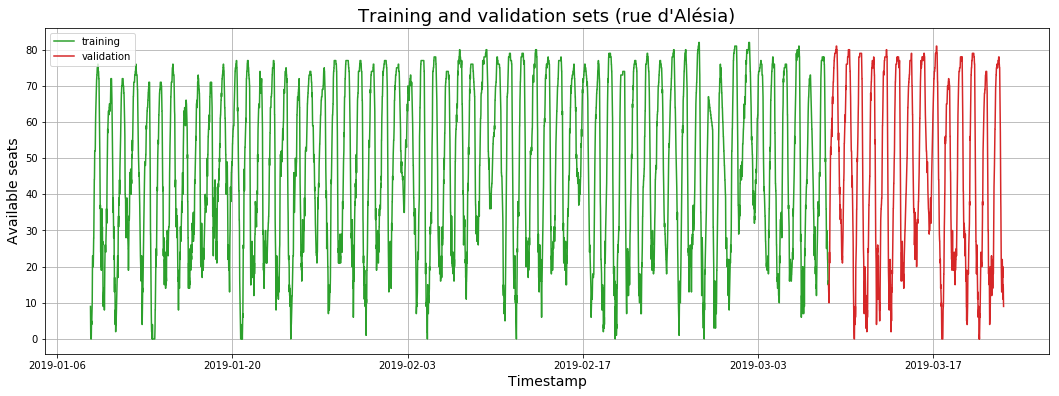

In [17]:
fig, ax = plt.subplots(figsize=(18, 6));

plt.plot(timestamps_train['timestamp'], y_train, COL_TRAIN);
plt.plot(timestamps_valid['timestamp'], y_valid, COL_VALID);

ax.set_title("Training and validation sets (rue d'Alésia)", fontsize=18)

ax.set_ylabel("Available seats", fontsize=14);
ax.set_yticks(range(0, 90, 10));

ax.set_xlabel("Timestamp", fontsize=14);

ax.legend(['training', 'validation'], loc='upper left');
ax.grid();
# plt.savefig("alesia-training-validation-split.png")

Again, near optimal choices for the parameters have been determined empirically, and for the dataset from rue d'Alésia we set:

In [18]:
nb_trees, max_features, min_leaves = 100, 14, 14

In [19]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=nb_trees, max_features=max_features, min_samples_leaf=min_leaves)
%time m.fit(X_train, y_train)
COL_WIDTH = 20
print("{0}: {1}".format("RMSE (train)".ljust(COL_WIDTH), rmse(m.predict(X_train), y_train)))
print("{0}: {1}".format("RMSE (validation)".ljust(COL_WIDTH), rmse(m.predict(X_valid), y_valid)))
print("{0}: {1}".format("R2 (train)".ljust(COL_WIDTH), m.score(X_train, y_train)))
print("{0}: {1}".format("R2 (validation)".ljust(COL_WIDTH), m.score(X_valid, y_valid)))

y_predict = m.predict(X_valid)

CPU times: user 1.15 s, sys: 26 ms, total: 1.17 s
Wall time: 244 ms
RMSE (train)        : 3.742689963665619
RMSE (validation)   : 6.840394039432342
R2 (train)          : 0.973339643978373
R2 (validation)     : 0.9258356402698283


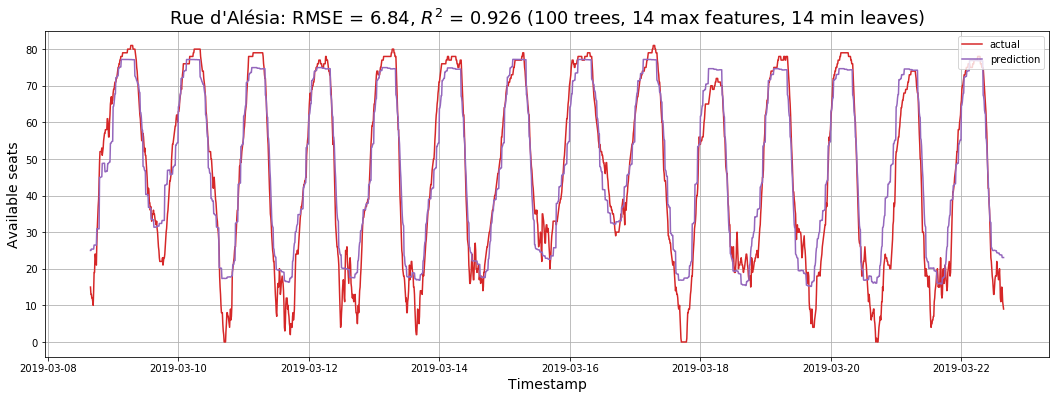

In [20]:
fig, ax = plt.subplots(figsize=(18, 6));
ax.plot(timestamps_valid['timestamp'], y_valid, COL_VALID);
ax.plot(timestamps_valid['timestamp'], y_predict, COL_PREDICT);
ax.set_title(
    "Rue d'Alésia: RMSE = {0:.4g}, $R^2$ = {1:.3g} ({2} trees, {3} max features, {4} min leaves)".format(
        rmse(m.predict(X_valid), y_valid),
        m.score(X_valid, y_valid),
        nb_trees,
        max_features,
        min_leaves
    ),
    fontsize=18
);

ax.set_ylabel("Available seats", fontsize=14);
ax.set_yticks(range(0, 90, 10));
ax.set_xlabel("Timestamp", fontsize=14);
ax.legend(['actual', 'prediction'], loc='upper right')
ax.grid();
# plt.savefig("moulin-random-forests.png");